# Data Wrangling

#### On this notebook, I am taking the necessary data, and organize it to complete my last project. I am doing a times series analysis for three different stocks traded in the New York Stock Exchange. I am doing the analysis to Apple, American Airlines, and Tesla. Additionally, to make this project more advanced, I am studying the correlation between those stock prices and the oil price. 

#### Firstly, I am importing the libraries we need to use to complete this step

In [1]:
#Import libraries
import pandas as pd
from pandas_datareader.data import DataReader
import datetime
import functools
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
import sys
import numpy as np

## Data Wrangling

I want to use a code that is reusable in case I want to add any other stock to our analysis.
I am using Data Reader to get the data from yahoo finance. This would give me the chance to get the data directly from the web without necessity of uploading any csv file.

After getting the data, I will convert the data to data frame to make the data easier to use.

In [2]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [3]:
#Define variables of data source, start and end date
start = datetime.date(2000,1,1)
end = datetime.date(2020,8,31)
source = 'yahoo'

In [4]:
#Get the data from the stocks we would like to make the data serie analysis
jks = stock_data('JKS', source, start, end)
aal = stock_data('AAL', source, start, end)
tsla = stock_data('TSLA', source, start, end)

I downloaded the oil data from quandl. We could also use Data Reader with an API key. To get the data we use the function the pandas function read_csv.

In [5]:
#Read the oil price
oil = pd.read_csv('OPEC-ORB.csv', index_col = 0)
oil.index = pd.to_datetime(oil.index)
oil.rename( columns = {'Value': 'Oil Price'}, inplace = True)

We also want to create a reusable code to merge different data frames. 

In [6]:
# Define a function to merge the different data frames
def merge_df(df1, df2, df3, df4):
    df = [df1, df2, df3, df4]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'inner', on = 'Date'), df)

In [7]:
#Data Frame we are going to make the times series
df = merge_df(oil, jks, aal,tsla).sort_values(by = 'Date', ascending = True)

# Data Frame overview

#### I am exploring the data we have to see if it is necessary to drop/replace Null-Values.

In [8]:
#Info function on the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2559 entries, 2010-06-29 to 2020-08-31
Data columns (total 4 columns):
Oil Price    2559 non-null float64
JKS          2559 non-null float64
AAL          2559 non-null float64
TSLA         2559 non-null float64
dtypes: float64(4)
memory usage: 100.0 KB


In [9]:
#Check if there is NaN values
df.isna().sum()

Oil Price    0
JKS          0
AAL          0
TSLA         0
dtype: int64

In [10]:
# See the first 5 heads
df.head(n = 5)

,Oil Price,JKS,AAL,TSLA
Date,,,,
2010-06-29,72.66,9.96,8.051013,4.778
2010-06-30,72.49,9.70,8.117004,4.766
2010-07-01,70.48,9.80,8.154712,4.392
2010-07-02,69.63,10.21,7.721052,3.840
2010-07-06,69.73,10.79,7.617351,3.222


## Data Visualization

On this step I want to see the stock behavior during time. I am also doing correlation hetmaps to see how the stocks move in relation with the oil price. Additionally, I am plotting autocorrelation graphics to know the order of the ARIMA or SARIMAX model. Finally, I am doing a seasonal decompose to see trend, seasonality of the data I got.

### Plot the Multiple times series 

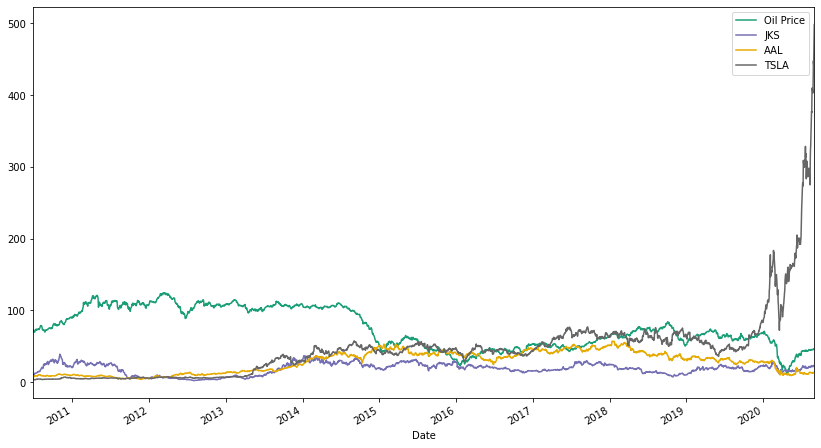

In [11]:
#Plot 
df.plot(cmap = 'Dark2', figsize = (14,8))
plt.legend(loc = 'best')
plt.show()

From the graphic above, we can see after 2019, Tesla stock dramatically increased its value over time. Right now, we could think Tesla stock would continue increasing the stock price for the momentum. Additionally, the oul price has fallen after 2015 (this because fracking was implemented and the majorist productors started competing with low price). For the correlation heatmap, we may use only the data available after 2019 to see the relation between oil and stock price recently and not being influenced by previous activities when oil price was really high and for example, Tesla stock was just on their beginning and the stock price was really low.

### Correlation among the stocks and the oil price

In [12]:
#Define the function to create the correlation matrix
def correlation_matrix(df, method):
    return df.corr(method = method)

In [13]:
#Define the function for the correlation heatmap
def correlation_matrix_heatmap(df, method):
    return sns.heatmap(df.corr(method = method))

In [14]:
# To create the correlation heatmap, we are using the data from 2019 to the present. 
# Tesla and Apple Stock increased their value dramatically, so this may badly influence our insights
df_corr = df.loc['2019-01-01':]

#### Pearson Correlation

In [15]:
#Correlation Matrix
correlation_matrix(df_corr, 'pearson')

,Oil Price,JKS,AAL,TSLA
Oil Price,1.000000,0.340030,0.894232,-0.532762
JKS,0.340030,1.000000,0.131747,0.196314
AAL,0.894232,0.131747,1.000000,-0.730361
TSLA,-0.532762,0.196314,-0.730361,1.000000


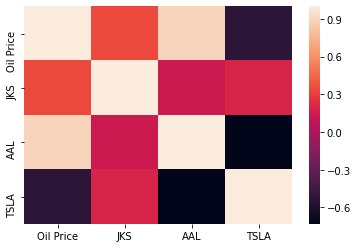

In [16]:
#Correlation heatmap
correlation_matrix_heatmap(df_corr, 'pearson')

#### Kendall Correlation

In [17]:
#Correlation Matrix
correlation_matrix(df_corr, 'kendall')

,Oil Price,JKS,AAL,TSLA
Oil Price,1.000000,0.212667,0.578669,-0.378112
JKS,0.212667,1.000000,0.063673,-0.026380
AAL,0.578669,0.063673,1.000000,-0.399332
TSLA,-0.378112,-0.026380,-0.399332,1.000000


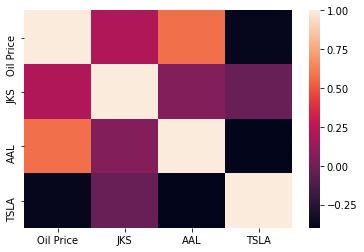

In [18]:
#Correlation Heatmap
correlation_matrix_heatmap(df_corr, 'kendall')

#### Spearman Correlation

In [19]:
#Correlation Matrix
correlation_matrix(df_corr, 'spearman')

,Oil Price,JKS,AAL,TSLA
Oil Price,1.000000,0.314589,0.776885,-0.626441
JKS,0.314589,1.000000,0.089441,-0.028341
AAL,0.776885,0.089441,1.000000,-0.619296
TSLA,-0.626441,-0.028341,-0.619296,1.000000


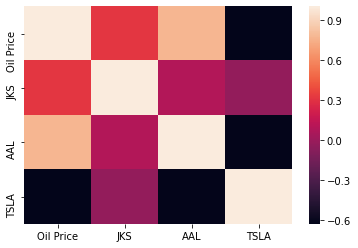

In [20]:
#Correlation Heatmap
correlation_matrix_heatmap(df_corr, 'spearman')

#### Insights from the correlation matrix

- As expected, Tesla stock is the less correlated with the oil price and American Airlines the most correlated with the oil price.


- Regarding the correlation result for American Airlines, we have a following hypothesis: If there is an increase on the oil price is because the increase of the demand. People around the world are traveling, so there is more customers on the airline industry, so therefore an increase on its revenues. If the company does well, investors acquire stocks, and therefore stock price also increases.


- For Tesla we have the following hypothesis: Oil prices roses the lowest value in their history. Tesla on the other hand, they have their highest stock price. To remark, oil prices are down and Tesla stock prices are high, so that's why we can support their negative correlation.  Same can be explained with Apple. 


- In the future, we could have the following hypothesis to what is going to happen between Tesla and its stock price: Oil prices could continue going down due to the use of fraking. People may not see Tesla as savings to their budget since it would be cheaper to just continue using regular gas, thereby Tesla revenues would go down and therefore their stock price as well. On the other hand, people may also want to help the work by making it more ecological can continue increasing Tesla revenues and therefore their stock price.


- JinkoSolar Holding is close to be not correlated with oil price. Therefore, we could conclude they are independ of how the oil price, but there is a small inclination that if oil price decrease, there would be an increase on the stocks. 


### Autocorrelation

In [21]:
stock_columns = list(df.columns)

In [22]:
#Define a data frame with the rate of return of the stocks and if the oil price increased, decreased or was the same
df_change = df.pct_change().dropna()

In [23]:
df_change.head(n = 5)

,Oil Price,JKS,AAL,TSLA
Date,,,,
2010-06-30,-0.002340,-0.026104,0.008197,-0.002512
2010-07-01,-0.027728,0.010309,0.004645,-0.078472
2010-07-02,-0.012060,0.041837,-0.053179,-0.125683
2010-07-06,0.001436,0.056807,-0.013431,-0.160938
2010-07-07,0.000143,0.148285,0.153466,-0.019243


In [24]:
## Define a function that plots the autocorrelation
def plot_autocorrelation(x, lags, alpha):
    fig = plot_acf(x, lags = lags, alpha = alpha)
    return plt.show()

Oil Price


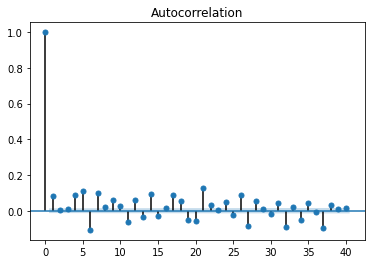

JKS


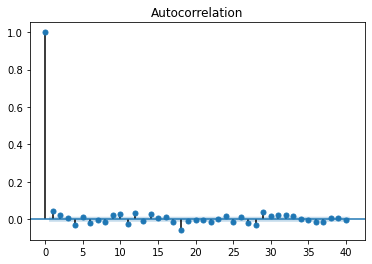

AAL


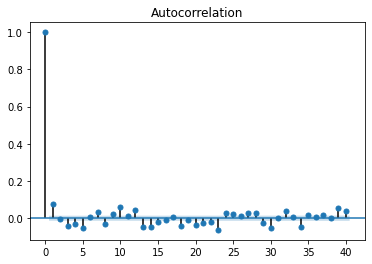

TSLA


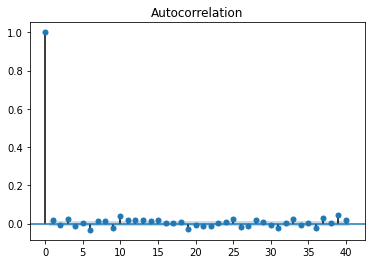

In [25]:
for col in stock_columns:
    print(col)
    plot_autocorrelation(df_change[col], lags = 40, alpha = 0.5)

#### Key Insights

- From the autocorrelation plots,we may conclude that all the stocks and also the oil price is order 1.

### Decomposition Analysis

In [26]:
def decomposition_analysis(x, model, freq):
    return seasonal_decompose(x = x , model = model , freq = freq)

In [27]:
#Apply the function for the columns
stocks_decompose = []
trends = []
seasonals = []
residuals = []
observeds = []

for stock in stock_columns:
    #Decomposition
    decomposition = decomposition_analysis(x = df[stock], model = 'multiplicative', freq = 252)
    stocks_decompose.append(decomposition)
    
    #Trend
    trend = decomposition.trend
    trends.append(trend)
    
    #Seasonal
    seasonal = decomposition.seasonal
    seasonals.append(seasonal)
    
    #Residual
    residual = decomposition.resid
    residuals.append(residual)
    
    #Observed
    observed = decomposition.observed
    observeds.append(observed)

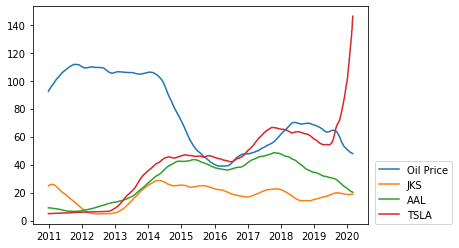

In [28]:
#Plot the trend for the stocks
for i, j in enumerate(stock_columns):
    plt.plot(trends[i], label = j)
    plt.legend(loc = (1.02, 0))
    continue

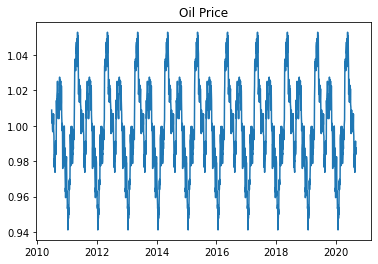

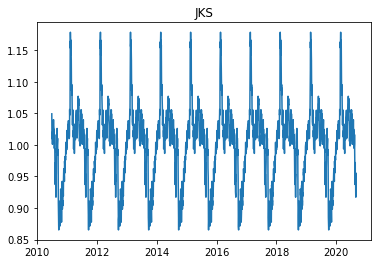

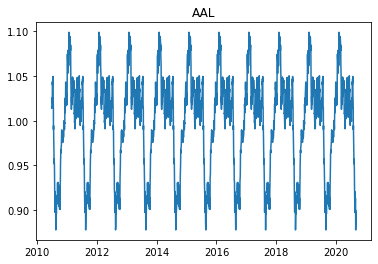

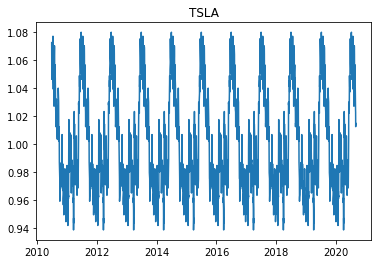

In [29]:
#Plot the seasonals for stocks
for i, j in enumerate(stock_columns):
    plt.plot(seasonals[i])
    plt.title(j)
    plt.show()

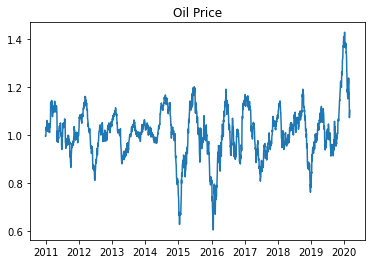

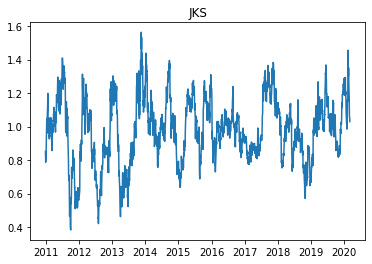

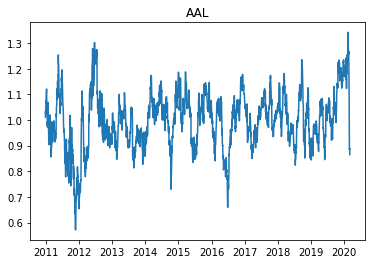

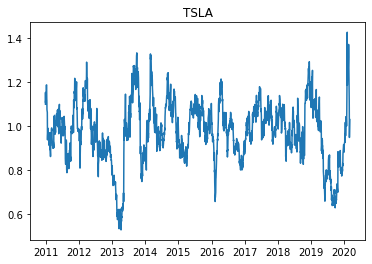

In [30]:
#Plot the residuals for each stock
for i, j in enumerate(stock_columns):
    plt.plot(residuals[i])
    plt.title(j)
    plt.show()
    continue

From the graphics, I concluded that Oil Price is very volatile, but the overall trend is to decrease.


For American Airlines, it was increasing its stock price, but recently their stock is going down as well. 


JKS has had a very stable stock price. Interestingly, before Tesla booming, this stock was having a similar behavoir than Tesla. It may be probable this stock would increase its value somewhen.

Stocks are very similar regarding their stationarity and all of the stocks have similar value on their residuals as well.

# Train and test dataset

#### We are creating the data frames to create the train and test data set.

#### We are also standarizing the data available


We are creating different X and Y arrays for each method. With method I'm referring to regression methods and sesonality methods

### Create the y and x arrays  for Regressions

In [31]:
#Divide between train and test data
#For time series, we would divide in consecutive train and test data set

In [32]:
#Reset Index to have date as categorical variables to run linear models
df2 = df.reset_index(inplace = True)

In [33]:
#Create the Date as categorical variables
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

In [34]:
#Drop the current date column
df2 = df.drop(columns = 'Date', axis = 1, inplace = True)

In [35]:
#Concat the data frame data function as categorical variable with the stock and oil prices
df2 = pd.concat([df_date, df], axis = 1)

In [36]:
#See how the data frame looks like 
df2.head()

,Year,Month,Day,Oil Price,JKS,AAL,TSLA
0,2010,6,29,72.66,9.96,8.051013,4.778
1,2010,6,30,72.49,9.70,8.117004,4.766
2,2010,7,1,70.48,9.80,8.154712,4.392
3,2010,7,2,69.63,10.21,7.721052,3.840
4,2010,7,6,69.73,10.79,7.617351,3.222


In [37]:
#Create our X array for the regressions
X = df2[['Year','Month', 'Day', 'Oil Price']].values

In [38]:
#Create the y arrays
y = df2.iloc[:,4:].values

In [39]:
#Dependant Variable
y_oil = df2['Oil Price']
y_jks = df2['JKS']
y_aal = df2['AAL']
y_tsla = df2['TSLA']

#### Divide into train and test data

In [40]:
#Define the 80% of the data as train data and 20% as test data
q3 = int(len(y)*0.8)
q1 = int(len(y) *0.2)

In [41]:
#Define train function
def train(array):
    return array[:q3]

In [42]:
#Define test
def test(array):
    return array[q3:]

In [43]:
#X train and test array
X_train = train(X)
X_test = test(X)

In [44]:
# y train and test array
y_train = train(y)
y_test = test(y)

#### Define arrays for each stock

In [45]:
#Apple Stock
y_jks_train = [i[0] for i in y_train]
y_jks_test = [i[0] for i in y_test]

In [46]:
# American Airlines Stock
y_aal_train = [i[1] for i in y_train]
y_aal_test = [i[1] for i in y_test]

In [47]:
#Tesla Stock
y_tsla_train = [i[2] for i in y_train]
y_tsla_test = [i[2] for i in y_test]

In [48]:
# Create the Train Dataset using pd.DataFrame and pd.concat
df_train = pd.concat([pd.DataFrame(data = X_train, columns = ['Year', 'Month', 'Day', 'Oil Price']), pd.DataFrame({'JKS':
    y_jks_train, 'AAL': y_aal_train, 'TSLA': y_tsla_train})], axis = 1)


In [49]:
df_train.head()

,Year,Month,Day,Oil Price,JKS,AAL,TSLA
0,2010.0,6.0,29.0,72.66,9.96,8.051013,4.778
1,2010.0,6.0,30.0,72.49,9.70,8.117004,4.766
2,2010.0,7.0,1.0,70.48,9.80,8.154712,4.392
3,2010.0,7.0,2.0,69.63,10.21,7.721052,3.840
4,2010.0,7.0,6.0,69.73,10.79,7.617351,3.222


In [50]:
# Create the test Dataset using pd.DataFrame and pd.concat
df_test = pd.concat([pd.DataFrame(data = X_test, columns = ['Year', 'Month', 'Day', 'Oil Price']), pd.DataFrame({'JKS':
    y_jks_test, 'AAL': y_aal_test, 'TSLA': y_tsla_test})], axis = 1)

In [51]:
df_test.head()

,Year,Month,Day,Oil Price,JKS,AAL,TSLA
0,2018.0,8.0,16.0,69.47,12.91,37.449406,67.089996
1,2018.0,8.0,17.0,70.27,12.23,37.086296,61.099998
2,2018.0,8.0,20.0,70.64,12.32,39.245338,61.688000
3,2018.0,8.0,21.0,71.01,12.49,39.578999,64.379997
4,2018.0,8.0,22.0,71.75,12.36,38.460224,64.328003


## Standarization

I am also doing standarization in order to compare the results between standarized and not standarized data and see which model performs the best.

#### Standarization

In [52]:
#Import the library
from sklearn.preprocessing import StandardScaler

In [53]:
#Apply the scaler on the x_train
def scaler(array):
    scaler = StandardScaler()
    return scaler.fit_transform(array)

In [54]:
# Standarization 
X_train_scaler = scaler(X_train)
X_test_scaler = scaler(X_test)

In [55]:
#Creating the train dataset for the train standarized data
df_train_scaler = pd.concat([pd.DataFrame(data = X_train_scaler, columns = ['Year', 'Month', 'Day', 'Oil Price']), pd.DataFrame({'JKS':
    y_jks_train, 'AAL': y_aal_train, 'TSLA': y_tsla_train})], axis = 1)

In [56]:
df_train_scaler.head()

,Year,Month,Day,Oil Price,JKS,AAL,TSLA
0,-1.70112,-0.163031,1.521254,-0.236437,9.96,8.051013,4.778
1,-1.70112,-0.163031,1.635529,-0.242516,9.70,8.117004,4.766
2,-1.70112,0.131258,-1.678459,-0.314386,9.80,8.154712,4.392
3,-1.70112,0.131258,-1.564184,-0.344778,10.21,7.721052,3.840
4,-1.70112,0.131258,-1.107082,-0.341203,10.79,7.617351,3.222


In [57]:
#Create the test dataset for the test standarized data
df_test_scaler = pd.concat([pd.DataFrame(data = X_test_scaler, columns = ['Year', 'Month', 'Day', 'Oil Price']), pd.DataFrame({'JKS':
    y_jks_test, 'AAL': y_aal_test, 'TSLA': y_tsla_test})], axis = 1)

In [58]:
df_test_scaler.head()

,Year,Month,Day,Oil Price,JKS,AAL,TSLA
0,-1.647738,0.434886,0.002907,0.765317,12.91,37.449406,67.089996
1,-1.647738,0.434886,0.117405,0.816212,12.23,37.086296,61.099998
2,-1.647738,0.434886,0.460900,0.839750,12.32,39.245338,61.688000
3,-1.647738,0.434886,0.575398,0.863289,12.49,39.578999,64.379997
4,-1.647738,0.434886,0.689896,0.910367,12.36,38.460224,64.328003


## Data Wrangling Times Series Analysis

In this step, we are making a times series analysis in order to predict the different stock prices. This is the methodology we are following:

- Check if the data is stationary by using kpss.

- If data is not stationalry, we are making them stationary using logarithms.  

In [59]:
def transform_log(y):
    return np.log(y)

### Check if the data is stationary

In [60]:
#Firstly we need to set a higher recursion limit
sys.setrecursionlimit(10000)

In [61]:
#Check if Oil is Stationary
warnings.simplefilter('ignore')
kpss(y_oil)

(5.440463061940448,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [62]:
#Check if Apple Stock Price is stationary
kpss(y_jks)

(0.6309868504740087,
 0.01981937722963557,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [63]:
#Check if American Airlines data is stationary
kpss(y_aal)

(4.5799140336336945,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [64]:
#Check if Tesla Stock Price is stationary
kpss(y_tsla)

(4.741163872953131,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Insights

- For all of the stocks, the data is not stationary since we got a p-value less than 0.05 for all of them. Thereore, we need to make the data stationary by using np.log

### Making Data Stationary

In [65]:
# Oil p-value
y_oil_log = transform_log(y_oil)
kpss(y_oil_log.diff().dropna())

(0.059785057821304374,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [66]:
# Apple p-value
y_jks_log = transform_log(y_jks)
kpss(y_jks_log.diff().dropna())

(0.05689604830260006,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [67]:
# American Airlines p-value
y_aal_log = transform_log(y_aal)
kpss(y_aal_log.diff().dropna())

(0.3961933229944284,
 0.0787959814679188,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [68]:
# Tesla p-value
y_tsla_log = transform_log(y_tsla)
kpss(y_tsla_log.diff().dropna())

(0.18840587005251933,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Now, all the data is stationary since for all of them we have p-values higher than 0.05

## Define the X and y arrays for the stationary models

In [69]:
#Define arrays for ARIMA
# Oil Price
y_oil_train_log = y_oil_log[q1:]
y_oil_test_log = y_oil_log[:q1]

In [70]:
#Apple
y_jks_train_log = y_jks_log[q1:]
y_jks_test_log = y_jks_log[:q1]

In [71]:
#American Airlines
y_aal_train_log = y_aal_log[q1:]
y_aal_test_log = y_aal_log[:q1]

In [72]:
#Tesla
y_tsla_train_log = y_tsla_log[q1:]
y_tsla_test_log = y_tsla_log[:q1]

In [73]:
#Train dataset for stationary models
df_train2 = pd.DataFrame({'Oil Price': y_oil_train_log, 'JKS': y_jks_train_log, 'AAL': y_aal_train_log, 
              'TSLA': y_tsla_train_log })

In [74]:
df_train2.head()

,Oil Price,JKS,AAL,TSLA
511,4.572957,1.214913,2.542986,1.840232
512,4.567780,1.169381,2.573645,1.833221
513,4.572027,1.187843,2.588629,1.840867
514,4.578005,1.147402,2.577949,1.877937
515,4.596129,1.187843,2.611731,1.924249


In [75]:
#Test dataset for stationary models
df_test2 = pd.DataFrame({'Oil Price': y_oil_test_log, 'JKS': y_jks_test_log, 'AAL': y_aal_test_log, 
              'TSLA': y_tsla_test_log })

In [76]:
df_test2.head()

,Oil Price,JKS,AAL,TSLA
0,4.285791,2.298577,2.085798,1.564022
1,4.283449,2.272126,2.093961,1.561507
2,4.255329,2.282382,2.098596,1.479785
3,4.243196,2.323368,2.043951,1.345472
4,4.244631,2.378620,2.030429,1.170002
